1.beam search函数定义

In [5]:
def beam_search_generate(context,            #编码器编码获得的向量
                        batch_size=3,        #每批数据中包含的样本量
                        max_length=20,       
                        min_length=2,
                        num_beams=2,
                        bos_token_id=101,   #句子开头标志的token id
                        pad_token_id=0,     #用于填充的token id
                        eos_token_id=102,   #句子结束标志的token id
                        ):
    pass

2.在函数中主要执行以下三个步骤：
1)准备初始输入
2)在当前生成的序列长度未达到max_length时扩展生成序列
3)准备最终输出的序列

1)准备初始输入

In [ ]:
# 建立beam容器，每个样本一个
generated_hyps = [
    BeamHypotheses(num_beams, max_length, length_penalty, early_stopping=early_stopping)
    for _ in range(batch_size)
]

# 每个beam容器的得分，共batch_size*num_beams个
beam_scores = torch.zeros((batch_size, num_beams), dtype=torch.float, device=encoder_input_ids.device)
beam_scores = beam_scores.view(-1)

# 每个样本是否完成生成，共batch_size个
done = [False for _ in range(batch_size)]

# 为了并行计算，一次生成batch_size*num_beams个序列
# 第一步自动填入bos_token
input_ids = torch.full(
    (batch_size*num_beams, 1),  
    bos_token_id,
    dtype=torch.long,
    device=next(self.parameters()).device,
)

# 当前长度设为1
cur_len = 1

In [3]:
class BeamHypotheses(object):
    def __init__(self, num_beams, max_length, length_penalty):
        """
        Initialize n-best list of hypotheses.
        """
        self.max_length = max_length - 1  # ignoring bos_token
        self.num_beams = num_beams
        self.beams = []
        self.worst_score = 1e9

    def __len__(self):
        """
        Number of hypotheses in the list.
        """
        return len(self.beams)

    def add(self, hyp, sum_logprobs):
        """
        Add a new hypothesis to the list.
        """
        score = sum_logprobs / len(hyp) ** self.length_penalty
        if len(self) < self.num_beams or score > self.worst_score:
            # 可更新的情况：数量未饱和或超过最差得分
            self.beams.append((score, hyp))
            if len(self) > self.num_beams:
                # 数量饱和需要删掉一个最差的
                sorted_scores = sorted([(s, idx) for idx, (s, _) in enumerate(self.beams)])
                del self.beams[sorted_scores[0][1]]
                self.worst_score = sorted_scores[1][0]
            else:
                self.worst_score = min(score, self.worst_score)

    def is_done(self, best_sum_logprobs, cur_len=None):
        """
        相关样本是否已经完成生成。
        best_sum_logprobs是新的候选序列中的最高得分。
        """

        if len(self) < self.num_beams:
            return False
        else:
            if cur_len is None:
                cur_len = self.max_length
            cur_score = best_sum_logprobs / cur_len ** self.length_penalty
            # 是否最高分比当前保存的最低分还差
            ret = self.worst_score >= cur_score
            return ret

2)序列扩展

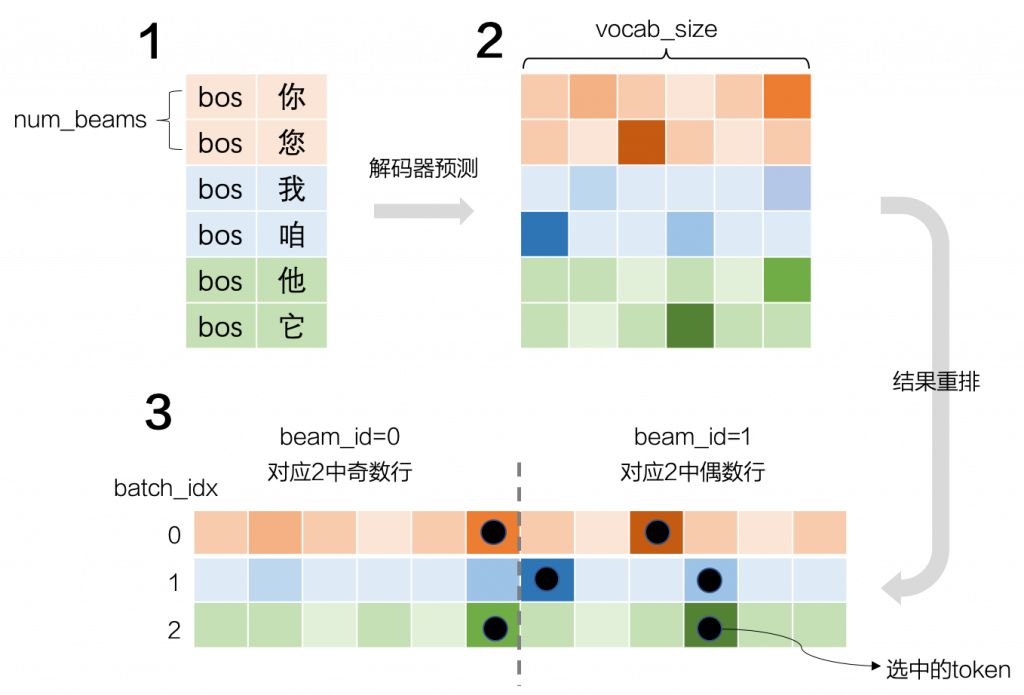

In [ ]:
while cur_len < max_length:
    # 将编码器得到的上下文向量和当前结果输入解码器，即图中1
    output = decoder.decode_next_step(context, input_ids)
    # 输出矩阵维度为：(batch*num_beams)*cur_len*vocab_size
    
    # 取出最后一个时间步的各token概率，即当前条件概率
    # (batch*num_beams)*vocab_size
    scores = next_token_logits = output[:, -1, :]  

    ###########################
    # 这里可以做一大堆操作减少重复 #
    ###########################

    # 计算序列条件概率的，因为取了log，所以直接相加即可。得到图中2矩阵
    # (batch_size * num_beams, vocab_size)
    next_scores = scores + beam_scores[:, None].expand_as(scores)  

    # 为了提速，将结果重排成图中3的形状
    next_scores = next_scores.view(
            batch_size, num_beams * vocab_size
        )  # (batch_size, num_beams * vocab_size)

    # 取出分数最高的token（图中黑点）和其对应得分
    # sorted=True，保证返回序列是有序的
    next_scores, next_tokens = torch.topk(next_scores, 2 * num_beams, dim=1, largest=True, sorted=True)

    # 下一个时间步整个batch的beam列表
    # 列表中的每一个元素都是三元组
    # (分数, token_id, beam_id)
    next_batch_beam = []

    # 对每一个样本进行扩展
    for batch_idx in range(batch_size):

        # 检查样本是否已经生成结束
        if done[batch_idx]:
            # 对于已经结束的句子，待添加的是pad token
            next_batch_beam.extend([(0, pad_token_id, 0)] * num_beams)  # pad the batch
            continue

        # 当前样本下一个时间步的beam列表
        next_sent_beam = []

        # 对于还未结束的样本需要找到分数最高的num_beams个扩展
        # 注意，next_scores和next_tokens是对应的
        # 而且已经按照next_scores排好顺序
        for beam_token_rank, (beam_token_id, beam_token_score) in enumerate(
            zip(next_tokens[batch_idx], next_scores[batch_idx])
        ):
            # get beam and word IDs
            # 这两行可参考图中3进行理解
            beam_id = beam_token_id // vocab_size 
            token_id = beam_token_id % vocab_size

            effective_beam_id = batch_idx * num_beams + beam_id

            # 如果出现了EOS token说明已经生成了完整句子
            if (eos_token_id is not None) and (token_id.item() == eos_token_id):
                # if beam_token does not belong to top num_beams tokens, it should not be added
                is_beam_token_worse_than_top_num_beams = beam_token_rank >= num_beams
                if is_beam_token_worse_than_top_num_beams:
                    continue
                # 往容器中添加这个序列
                generated_hyps[batch_idx].add(
                    input_ids[effective_beam_id].clone(), beam_token_score.item(),
                )
            else:
                # add next predicted word if it is not eos_token
                next_sent_beam.append((beam_token_score, token_id, effective_beam_id))

            # 扩展num_beams个就够了
            if len(next_sent_beam) == num_beams:
                break

        # 检查这个样本是否已经生成完了，有两种情况
        # 1. 已经记录过该样本结束
        # 2. 新的结果没有使结果改善
        done[batch_idx] = done[batch_idx] or generated_hyps[batch_idx].is_done(
            next_scores[batch_idx].max().item(), cur_len=cur_len
        )

        # 把当前样本的结果添加到batch结果的后面
        next_batch_beam.extend(next_sent_beam)

    # 如果全部样本都已经生成结束便可以直接退出了
    if all(done):
        break
    
    # 把三元组列表再还原成三个独立列表
    beam_scores = beam_scores.new([x[0] for x in next_batch_beam])
    beam_tokens = input_ids.new([x[1] for x in next_batch_beam])
    beam_idx = input_ids.new([x[2] for x in next_batch_beam])

    # 准备下一时刻的解码器输入
    # 取出实际被扩展的beam
    input_ids = input_ids[beam_idx, :]
    # 在这些beam后面接上新生成的token
    input_ids = torch.cat([input_ids, beam_tokens.unsqueeze(1)], dim=-1)

    # 更新当前长度
    cur_len = cur_len + 1
    # end of length while

注意两点：
1.只有出现了EOS token才会将生成的序列装进该样本对应的容器中
2.当前input_ids保存着当前得分最高的num_beams个序列

3）准备输出

In [ ]:
while循环跳出意味着已经生成了长度为max_length的文本，比较理想的情况是所有的句子都已经生成出了eos_token_id，即句子生成结束了。
但并不是所有情况都这样，对于那些没有完成的样本，我们需要先手动结束。

In [ ]:
# 将未结束的生成结果结束，并置入容器中
for batch_idx in range(batch_size):
    # 已经结束的样本不需处理
    if done[batch_idx]:
        continue

    # 把结果加入到generated_hyps容器
    for beam_id in range(num_beams):
        effective_beam_id = batch_idx * num_beams + beam_id
        final_score = beam_scores[effective_beam_id].item()
        final_tokens = input_ids[effective_beam_id]
        generated_hyps[batch_idx].add(final_tokens, final_score)

In [ ]:
所有生成好的句子都已经保存在generated_hyps容器中，每个容器内保存着num_beams个序列，最后就是输出期望个数的句子。

In [ ]:
# select the best hypotheses，最终输出
# 每个样本返回几个句子
output_num_return_sequences_per_batch = 1
# 记录每个返回句子的长度，用于后面pad
sent_lengths = input_ids.new(output_batch_size)
best = []

# 对每个样本取出最好的output_num_return_sequences_per_batch个句子
for i, hypotheses in enumerate(generated_hyps):
    sorted_hyps = sorted(hypotheses.beams, key=lambda x: x[0])
    for j in range(output_num_return_sequences_per_batch):
        effective_batch_idx = output_num_return_sequences_per_batch * i + j
        best_hyp = sorted_hyps.pop()[1]
        sent_lengths[effective_batch_idx] = len(best_hyp)
        best.append(best_hyp)

# 如果长短不一则pad句子，使得最后返回结果的长度一样
if sent_lengths.min().item() != sent_lengths.max().item():
    sent_max_len = min(sent_lengths.max().item() + 1, max_length)
    # 先把输出矩阵填满PAD token
    decoded = input_ids.new(output_batch_size, sent_max_len).fill_(pad_token_id)

    # 填入真正的内容
    for i, hypo in enumerate(best):
        decoded[i, : sent_lengths[i]] = hypo
        # 填上eos token
        if sent_lengths[i] < max_length:
            decoded[i, sent_lengths[i]] = eos_token_id
else:
    # 所有生成序列都还没结束，直接堆叠即可
    decoded = torch.stack(best).type(torch.long).to(next(self.parameters()).device)

# 返回的结果包含BOS token
return decoded